# Classification Feature Importances

## Setup

### Library Imports

In [1]:
import os, re
from pathlib import Path

### Path Dictionary

In [2]:
path = {'root': Path(os.getcwd()).parent}

tile, selection = 'cviel', '100k20x3_2'
# tile, selection = 'cviel', '100k20x3'

path['features'] = Path(path['root'], 'classification', 'features')
tilesamples = Path(path['features'], 'samples', tile)
path['samples'] = Path(tilesamples, selection, f'{selection}.parquet')

path['allpoints'] = Path(tilesamples, 'allpoints', f'allpoints.parquet')
path['centroids'] = Path(tilesamples, 'centroids', f'centroids.parquet')

path['results'] = Path(path['features'], 'results', tile, selection)
path['search'] = Path(path['results'], 'search')

path['nom_path'] = Path(path['root'], 'vector_data', 'nomenclature', 'nomenclature_revue_v1.csv')
path

{'root': PosixPath('/work/OT/biomass/tharen/forest-mapping'),
 'features': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features'),
 'samples': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/samples/cviel/100k20x3_2/100k20x3_2.parquet'),
 'allpoints': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/samples/cviel/allpoints/allpoints.parquet'),
 'centroids': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/samples/cviel/centroids/centroids.parquet'),
 'results': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/results/cviel/100k20x3_2'),
 'search': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/results/cviel/100k20x3_2/search'),
 'nom_path': PosixPath('/work/OT/biomass/tharen/forest-mapping/vector_data/nomenclature/nomenclature_revue_v1.csv')}

In [3]:
import pandas as pd
nompd = pd.read_csv(path['nom_path'], sep=';')

remove = [14, 15]
codes = nompd[nompd.consid==1 & ~nompd.CODE_merge.isin(remove)][['CODE_merge', 'Name_merge', 'Description_en']]
codes['Description_en'] = codes.groupby(['CODE_merge', 'Name_merge'])['Description_en'].transform(lambda x: ', '.join(x))
codes = codes.drop_duplicates()

# Manually edit descriptions
codes.loc[18, 'Description_en'] = 'Larix decidua and Mixed coniferous forest'
codes.loc[23, 'Description_en'] = 'Mix of deciduous and coniferous'

codes

CODE_merge Name_merge                                   Description_en
2            3        CHE                                   Deciduous oaks
3            9     FF_div    Evergreen oaks, Beech, Mixed deciduous forest
5            6        CHT                                        Chessnuts
6            7        ROB                             Robinia pseudoacacia
10          11         PM                                    Maritime pine
11          12         PS                                       Scots pine
12          17        PIN  Pinus nigra, Other pure pine, Mixed pine forest
13          17         PH                                 Pinus halepensis
14          17         PC                  Pinus uncinata and pinus cembra
17          18      SP_EP                                    Fir or Spruce
18          23     FC_div        Larix decidua and Mixed coniferous forest
19          20        DOU                                      Douglas fir
23          25      F_mix                  Mix of deciduous and coniferous
29          30        PEU                               Populus plantation

In [4]:
prefix = 'code_'

nomenclature = {}
nomenclature['codes'] = dict(zip([f'{prefix}{code}' for code in codes.CODE_merge], codes.Name_merge))
nomenclature['abbrv'] = dict(zip(codes.Name_merge, codes.Description_en))
nomenclature

{'codes': {'code_3': 'CHE',
  'code_9': 'FF_div',
  'code_6': 'CHT',
  'code_7': 'ROB',
  'code_11': 'PM',
  'code_12': 'PS',
  'code_17': 'PC',
  'code_18': 'SP_EP',
  'code_23': 'FC_div',
  'code_20': 'DOU',
  'code_25': 'F_mix',
  'code_30': 'PEU'},
 'abbrv': {'CHE': 'Deciduous oaks',
  'FF_div': 'Evergreen oaks, Beech, Mixed deciduous forest',
  'CHT': 'Chessnuts',
  'ROB': 'Robinia pseudoacacia',
  'PM': 'Maritime pine',
  'PS': 'Scots pine',
  'PIN': 'Pinus nigra, Other pure pine, Mixed pine forest',
  'PH': 'Pinus halepensis',
  'PC': 'Pinus uncinata and pinus cembra',
  'SP_EP': 'Fir or Spruce',
  'FC_div': 'Larix decidua and Mixed coniferous forest',
  'DOU': 'Douglas fir',
  'F_mix': 'Mix of deciduous and coniferous',
  'PEU': 'Populus plantation'}}

## Setup Pipeline

In [5]:
# import rfpimp
import pickle
import dask.dataframe as dd

from modules.classification import Classification, ConfusionMatrix, RFVisualisation
cl = Classification(verbose=True)

In [6]:
from dask.distributed import Client

client = Client(processes=False)
client

<Client: 'inproc://10.120.43.10/110503/1' processes=1 threads=16, memory=64.42 GB>

In [7]:
allcolumns = dd.read_parquet(path['samples']).columns
# print('\"', *sorted({c[3:] for c in allcolumns if 'code' not in c}), '\"', sep='\",\n\"')

In [8]:
s2_bands = ["B2:Blue:490", "B3:Green:560", "B4:Red:670", "B5:Vegetation red edge:705", "B6:Vegetation red edge:740", "B7:Vegetation red edge:780", "B8:NIR:820", "B8A:Narrow NIR:865", "B11:SWIR:1650", "B12:SWIR:2200"]
gray_stats = ["Gray:Kurtosis", "Gray:Mean", "Gray:Skewness", "Gray:Variance",]

o_indices = ["Soil:BI2", "Vegetation:NDRE", "Vegetation:NDVI", "Water:NDWI",]

bi_all_stats = ["BI2:Kurtosis", "BI2:Mean", "BI2:Skewness", "BI2:Variance",]
ndre_all_stats = ["NDRE:Kurtosis", "NDRE:Mean", "NDRE:Skewness", "NDRE:Variance",]
ndvi_all_stats = ["NDVI:Kurtosis", "NDVI:Mean", "NDVI:Skewness", "NDVI:Variance",]
ndwi_all_stats = ["NDWI:Kurtosis", "NDWI:Mean", "NDWI:Skewness", "NDWI:Variance",]

o_ind_all_stats = bi_all_stats + ndre_all_stats + ndvi_all_stats + ndwi_all_stats
o_ind_stats = ["BI2:Mean", "BI2:Variance",
                "NDRE:Mean", "NDRE:Variance",
                "NDVI:Mean", "NDVI:Variance",
                "NDWI:Mean", "NDWI:Variance",]

sar_bands = ["vh_asc", "vh_des", "vv_asc", "vv_des",]
sar_stats = ["vh_asc:Mean", "vh_asc:Variance",
                "vh_des:Mean", "vh_des:Variance",
                "vv_asc:Mean", "vv_asc:Variance",
                "vv_des:Mean", "vv_des:Variance",]
sar_all_stats = ["vh_asc:Kurtosis", "vh_asc:Mean", "vh_asc:Skewness", "vh_asc:Variance",
                "vh_des:Kurtosis", "vh_des:Mean", "vh_des:Skewness", "vh_des:Variance",
                "vv_asc:Kurtosis", "vv_asc:Mean", "vv_asc:Skewness", "vv_asc:Variance",
                "vv_des:Kurtosis", "vv_des:Mean", "vv_des:Skewness", "vv_des:Variance",]
sar_indices = ["SAR:RVI:ASC", "SAR:RVI:DES", "SAR:VH/VV:ASC", "SAR:VH/VV:DES",]

## Model Classification

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score

import numpy as np
import joblib

import tensorflow.keras as keras
from scikeras.wrappers import KerasClassifier

def rf_classifier(modelargs={}):
    return RandomForestClassifier(oob_score=True, n_jobs=-1, **modelargs)

def sharkrf_classifier(modelargs={}):
    return RandomForestClassifier(n_estimators=100, 
                                 min_samples_split=25,
                                 max_features='sqrt',
                                 oob_score=True, max_samples=0.66,
                                 n_jobs=-1, **modelargs)

def fcn_model(layers_widths, meta, dropout=False):
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]
    
    model = keras.models.Sequential()
    
    # Input Layer
    model.add(keras.layers.Dense(n_features_in_, input_shape=X_shape_[1:], activation='relu'))
    if dropout:
        model.add(keras.layers.Dropout(dropout))
    
    # len(layers_widths) > 1 => Deep Feed Foward
    for neurons, layers in layers_widths:
        for _ in range(layers):
            model.add(keras.layers.Dense(neurons, activation='relu'))
        if dropout:
            model.add(keras.layers.Dropout(dropout))
    
    # Output Layer
    model.add(keras.layers.Dense(n_classes_, activation='softmax'))
    return model

def get_model_fcn(resultspath, description, layers_widths=[], dropout=None, 
                  datetime=False, modelargs={}):
    
    f_name = '-'.join(
        [f'{neurons}x{layers}' for neurons, layers in layers_widths])
    if dropout:
        f_name += f'-Dropx{dropout}'
    
    callback_parameters = cl.default_callbacks(f_name, resultspath, datetime, 
                                               default_name=description)
    description, modelpath, callbacks = callback_parameters
    
    classifier = KerasClassifier(fcn_model, 
                           layers_widths=layers_widths, 
                           epochs=1000, # Remember stops earlier by callback..
                           optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'],
                           callbacks=callbacks,
                           **modelargs)
    
    return description, modelpath, classifier

def configure_scikeras(description, layers_widths=[], dropout=False, modelargs={}, 
                       resultspath=path['results'], **config):
    
    model_parameters = get_model_fcn(resultspath, description, 
                                     layers_widths, dropout, modelargs)
    description, modelpath, classifier = model_parameters
    
    config['description'] = description
    config['classifier'] = classifier
    config['modelpath'] = modelpath
    config['resultspath'] = resultspath
    return config

def get_evaluation_result(datadict):
    # datalabels = ['model', 'description', 'validation', 'splits', 'featcols', 'report', 'confmat', 'pickle']
    X_train, X_test, y_train, y_test = list(map(lambda s: s.shape, datadict['splits']))
    
    report = datadict['report']
    mean_cv, std_cv = report['cv']['mean'], report['cv']['std']
    overall_acc, kappa, weighted_f1 = report['accuracy'], report['kappa'], report['weighted avg']['f1-score']
    cl.vprint()
    return {
        'description': datadict['description'], 'validation': datadict['validation'],
        'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test,
        'overall_acc': overall_acc, 'kappa': kappa, 'weighted_f1': weighted_f1,
        'model_type': datadict['model_type'], 'parameters': datadict['parameters'],
        'conf_path': datadict['confmat'], 'model_path': datadict['model'], 
        'pkl_path': datadict['pickle']
    }

def load_result_pickle(pkl_path):
    with open(pkl_path, 'rb') as f:
        evaluation_data = pickle.load(f)
        validation = evaluation_data["validation"]
        validation_type = 'Test Size' if isinstance(validation, (int, float)) else 'Validation'
        cl.vprint(f'{validation_type}:\t{validation}')
            
        splits = list(map(lambda s: s.shape, evaluation_data['splits']))
        cl.vprint(f'Split Shapes:\t{splits}')

        report = evaluation_data['report']
        cl.vprint('Mean: %.3f (Std: %.3f)' % (report['cv']['mean'], report['cv']['std']))
        cl.vprint('Overall: %.3f  Kappa: %.3f' % (report['accuracy'], report['kappa']))
        cl.vprint('Weighted F1-Score: %.3f' % (report['weighted avg']['f1-score']))
        return get_evaluation_result(evaluation_data)

def preprocessing_sample(featureset, allcolumns, sample, imbalance, label, validation, scaler):
    cols = ['code']+[c for l in featureset for c in allcolumns if c.endswith(l)]
    featuresdf = cl.load_features(sample, cols)
    
    if imbalance is not None:
        featuresdf = cl.resample_features(featuresdf, imbalance)
    else:
        szdf = featuresdf.groupby(by='code').size()
        imbalance = round(szdf.max()/szdf.min(), 1)
            
    splits, featcols, validation = cl.split_features(featuresdf, label, validation, scaler)
    return splits, featcols, validation, imbalance

def postprocessing_model(model, description, validation, splits, featcols, tileset, imbalance, 
                         label, total, resultspath, nomenclature, model_path, pkl_path):
    
    # TODO: This is making an assumption that only paths for SciKeras model are given
    model_type = 'SciKeras' if model_path else 'Scikit-Learn'
    
    # Evaluation Metrics
    model, score = cl.evaluate_model(model, *splits)
    
    # Save Models
    if model_path:
        ## Keras Models can be saved through callbacks, but path is provided
        ### https://www.adriangb.com/scikeras/refs/heads/master/notebooks/
        ###        Basic_Usage.html#4.2-Saving-using-Keras'-saving-methods
        model_path.parent.mkdir(parents=True, exist_ok=True)
        model.model_.save(model_path)
    else: 
        ## Save sklearn model through joblib
        model_path = Path(resultspath, 'models', f'{description}.joblib')
        model_path.parent.mkdir(parents=True, exist_ok=True)
        joblib.dump(model, model_path)
    
    columns, report, true_matrix, pred_matrix = cl.classification_metrics(model, splits, score)
    
    cm_filename = f'{tileset} Confusion Matrix {description}'
    cm_title = f'{cm_filename} (Imbalance {imbalance}, Total Samples {total}, {validation})'
    cm_path = Path(resultspath, 'matrices', f'{cm_filename}.svg')
    cm_path.parent.mkdir(parents=True, exist_ok=True)
    cm = ConfusionMatrix(columns, nomenclature, report, true_matrix, pred_matrix, 
                         cm_path, title=cm_title, prefix=f'{label}_')
    
    pkl_path.parent.mkdir(parents=True, exist_ok=True)
    evaluation_data = {'model': model_path,
                       'model_type': model_type,
                       'parameters': str(model.get_params()),
                       'description': description,
                       'validation': validation,
                       'splits': splits,
                       'featcols': featcols,
                       'report': report, 
                       'confmat': cm_path,
                       'pickle': pkl_path}
    
    with open(pkl_path, 'wb') as f:
        pickle.dump(evaluation_data, f, pickle.HIGHEST_PROTOCOL)
    
    return get_evaluation_result(evaluation_data)

def evaluate_sample(featureset, description, classifier=rf_classifier(), 
                    sample=path['samples'], scaler=StandardScaler, 
                    validation=0.2, imbalance=None,
                    allcolumns=allcolumns, label='code', tileset='CVieL', 
                    nomenclature=nomenclature, 
                    modelpath=None, resultspath=path['results'], 
                    overwrite=False):
    
    cl.vprint(f'Description:\t{description}')
    
    pkl_path = Path(resultspath, 'pickles', f'{description}.pickle')
    if not overwrite and pkl_path.is_file():
        cl.vprint('Run Exists! Loading from pickle...')
        return load_result_pickle(pkl_path)        
    
    preprocess = preprocessing_sample(featureset, allcolumns, sample, imbalance, 
                                      label, validation, scaler)
    splits, featcols, validation, imbalance = preprocess
    X_train, X_test, y_train, y_test = splits
    
    return postprocessing_model(classifier, description, validation, splits, featcols, 
                                tileset, imbalance, label, len(X_train)+len(X_test), 
                                resultspath, nomenclature, modelpath, pkl_path)

In [10]:
# evaluate_sample(**configure_scikeras(**{'featureset': o_ind_stats, 'classifier': get_model_fcn, 'layers_widths': [(128, 1)], 'dropout': 0.2,
#                                         'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with FCN'}))

In [11]:
# evaluate_sample(**{'featureset': o_ind_stats, 'description': 'S2 indices mean and variance'})

### Models

In [33]:
evalconfig=[
    {'featureset': s2_bands, 'description': 'S2 bands'},
    {'featureset': s2_bands, 'validation': path['centroids'], 'description': 'S2 bands with centroid validation'},
    {'featureset': s2_bands, 'validation': path['allpoints'], 'description': 'S2 bands with all points validation'},
    {'featureset': o_ind_stats, 'description': 'S2 indices mean and variance'},
    {'featureset': o_ind_stats, 'validation': path['centroids'], 'description': 'S2 indices mean and variance with centroid validation'},
    {'featureset': o_ind_stats, 'validation': path['allpoints'], 'description': 'S2 indices mean and variance with all points validation'},
    {'featureset': s2_bands, 'scaler': StandardScaler, 'description': 'S2 bands with StandardScaler'},
    {'featureset': s2_bands, 'validation': path['centroids'], 'scaler': StandardScaler, 'description': 'S2 bands with centroid validation with StandardScaler'},
    {'featureset': s2_bands, 'validation': path['allpoints'], 'scaler': StandardScaler, 'description': 'S2 bands with all points validation with StandardScaler'},
    {'featureset': o_ind_stats, 'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler'},
    {'featureset': o_ind_stats, 'validation': path['centroids'], 'scaler': StandardScaler, 'description': 'S2 indices mean and variance with centroid validation with StandardScaler'},
    {'featureset': o_ind_stats, 'validation': path['allpoints'], 'scaler': StandardScaler, 'description': 'S2 indices mean and variance with all points validation with StandardScaler'},
    {'featureset': s2_bands, 'scaler': MinMaxScaler, 'description': 'S2 bands with MinMaxScaler'},
    {'featureset': s2_bands, 'validation': path['centroids'], 'scaler': MinMaxScaler, 'description': 'S2 bands with centroid validation with MinMaxScaler'},
    {'featureset': s2_bands, 'validation': path['allpoints'], 'scaler': MinMaxScaler, 'description': 'S2 bands with all points validation with MinMaxScaler'},
    {'featureset': o_ind_stats, 'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with MinMaxScaler'},
    {'featureset': o_ind_stats, 'validation': path['centroids'], 'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with centroid validation with MinMaxScaler'},
    {'featureset': o_ind_stats, 'validation': path['allpoints'], 'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with all points validation with MinMaxScaler'}
]

layer_widths = [[(64, 1)], [(128, 1)], [(256, 1)],
                [(128, 1), (64, 1)], [(256, 1), (128, 1)],
                [(64, 2)], [(128, 2)], [(256, 2)],
                [(128, 2), (64, 1)], [(256, 2), (128, 1)],
                [(128, 1), (64, 2)], [(256, 1), (128, 2)],
               ]
dropout =  [None, .1] + list(map(lambda x: x/10.0, range(2, 10, 2)))

evalkerasconfig = [
    configure_scikeras(**c) 
    for c in [
        c for l in layer_widths for d in dropout 
        for c in [
            {'featureset': o_ind_stats, 'classifier': get_model_fcn, 'layers_widths': l, 'dropout': d,
             'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with FCN'},
            {'featureset': o_ind_stats, 'classifier': get_model_fcn, 'layers_widths': l, 'dropout': d,
             'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with MinMaxScaler with FCN'},
            {'featureset': s2_bands, 'classifier': get_model_fcn, 'layers_widths': l, 'dropout': d,
             'scaler': StandardScaler, 'description': 'S2 bands with StandardScaler with FCN'},
            {'featureset': s2_bands, 'classifier': get_model_fcn, 'layers_widths': l, 'dropout': d,
             'scaler': MinMaxScaler, 'description': 'S2 bands with MinMaxScaler with FCN'}
        ] 
    ]
]


evalconfig += evalkerasconfig

# cl.set_verbose(False)
results = pd.DataFrame([evaluate_sample(**c) for c in evalconfig]).sort_values(by='weighted_f1', ascending=False)
results_path = Path(path['results'], 'results.csv')
results.to_csv(results_path)
# cl.rchmod(results_path, path['features'])
results

### Features

In [ ]:
featurespath = Path(path['results'], 'features')

featconfig = [
    {'featureset': s2_bands, 'description': 's2_bands'},
    {'featureset': s2_bands+sar_bands, 'description': 's2_bands+sar_bands'},
    {'featureset': s2_bands+sar_bands+sar_stats, 'description': 's2_bands+sar_bands+sar_stats'},
    {'featureset': s2_bands+sar_bands+sar_all_stats, 'description': 's2_bands+sar_bands+sar_all_stats'},
    {'featureset': s2_bands+sar_bands+sar_indices, 'description': 's2_bands+sar_bands+sar_indices'},
    {'featureset': s2_bands+sar_bands+sar_indices+sar_stats, 'description': 's2_bands+sar_bands+sar_indices+sar_stats'},
    {'featureset': s2_bands+sar_bands+sar_indices+sar_all_stats, 'description': 's2_bands+sar_bands+sar_indices+sar_all_stats'},
    {'featureset': s2_bands+sar_indices, 'description': 's2_bands+sar_indices'},
    {'featureset': s2_bands+sar_indices+sar_stats, 'description': 's2_bands+sar_indices+sar_stats'},
    {'featureset': s2_bands+sar_indices+sar_all_stats, 'description': 's2_bands+sar_indices+sar_all_stats'},
    {'featureset': o_indices, 'description': 'o_indices'},
    {'featureset': o_indices+sar_bands, 'description': 'o_indices+sar_bands'},
    {'featureset': o_indices+sar_bands+sar_stats, 'description': 'o_indices+sar_bands+sar_stats'},
    {'featureset': o_indices+sar_bands+sar_all_stats, 'description': 'o_indices+sar_bands+sar_all_stats'},
    {'featureset': o_indices+sar_bands+sar_indices, 'description': 'o_indices+sar_bands+sar_indices'},
    {'featureset': o_indices+sar_bands+sar_indices+sar_stats, 'description': 'o_indices+sar_bands+sar_indices+sar_stats'},
    {'featureset': o_indices+sar_bands+sar_indices+sar_all_stats, 'description': 'o_indices+sar_bands+sar_indices+sar_all_stats'},
    {'featureset': o_indices+sar_indices, 'description': 'o_indices+sar_indices'},
    {'featureset': o_indices+sar_indices+sar_stats, 'description': 'o_indices+sar_indices+sar_stats'},
    {'featureset': o_indices+sar_indices+sar_all_stats, 'description': 'o_indices+sar_indices+sar_all_stats'},
    {'featureset': o_ind_all_stats, 'description': 'o_ind_all_stats'},
    {'featureset': o_ind_all_stats+sar_bands, 'description': 'o_ind_all_stats+sar_bands'},
    {'featureset': o_ind_all_stats+sar_bands+sar_stats, 'description': 'o_ind_all_stats+sar_bands+sar_stats'},
    {'featureset': o_ind_all_stats+sar_bands+sar_all_stats, 'description': 'o_ind_all_stats+sar_bands+sar_all_stats'},
    {'featureset': o_ind_all_stats+sar_bands+sar_indices, 'description': 'o_ind_all_stats+sar_bands+sar_indices'},
    {'featureset': o_ind_all_stats+sar_bands+sar_indices+sar_stats, 'description': 'o_ind_all_stats+sar_bands+sar_indices+sar_stats'},
    {'featureset': o_ind_all_stats+sar_bands+sar_indices+sar_all_stats, 'description': 'o_ind_all_stats+sar_bands+sar_indices+sar_all_stats'},
    {'featureset': o_ind_all_stats+sar_indices, 'description': 'o_ind_all_stats+sar_indices'},
    {'featureset': o_ind_all_stats+sar_indices+sar_stats, 'description': 'o_ind_all_stats+sar_indices+sar_stats'},
    {'featureset': o_ind_all_stats+sar_indices+sar_all_stats, 'description': 'o_ind_all_stats+sar_indices+sar_all_stats'},
    {'featureset': o_ind_stats, 'description': 'o_ind_stats'},
    {'featureset': o_ind_stats+sar_bands, 'description': 'o_ind_stats+sar_bands'},
    {'featureset': o_ind_stats+sar_bands+sar_stats, 'description': 'o_ind_stats+sar_bands+sar_stats'},
    {'featureset': o_ind_stats+sar_bands+sar_all_stats, 'description': 'o_ind_stats+sar_bands+sar_all_stats'},
    {'featureset': o_ind_stats+sar_bands+sar_indices, 'description': 'o_ind_stats+sar_bands+sar_indices'},
    {'featureset': o_ind_stats+sar_bands+sar_indices+sar_stats, 'description': 'o_ind_stats+sar_bands+sar_indices+sar_stats'},
    {'featureset': o_ind_stats+sar_bands+sar_indices+sar_all_stats, 'description': 'o_ind_stats+sar_bands+sar_indices+sar_all_stats'},
    {'featureset': o_ind_stats+sar_indices, 'description': 'o_ind_stats+sar_indices'},
    {'featureset': o_ind_stats+sar_indices+sar_stats, 'description': 'o_ind_stats+sar_indices+sar_stats'},
    {'featureset': o_ind_stats+sar_indices+sar_all_stats, 'description': 'o_ind_stats+sar_indices+sar_all_stats'},
    {'featureset': o_indices+o_ind_stats+sar_bands, 'description': 'o_indices+o_ind_stats+sar_bands'},
    {'featureset': o_indices+o_ind_stats+sar_bands+sar_stats, 'description': 'o_indices+o_ind_stats+sar_bands+sar_stats'},
    {'featureset': o_indices+o_ind_stats+sar_bands+sar_all_stats, 'description': 'o_indices+o_ind_stats+sar_bands+sar_all_stats'},
    {'featureset': o_indices+o_ind_stats+sar_bands+sar_indices, 'description': 'o_indices+o_ind_stats+sar_bands+sar_indices'},
    {'featureset': o_indices+o_ind_stats+sar_bands+sar_indices+sar_stats, 'description': 'o_indices+o_ind_stats+sar_bands+sar_indices+sar_stats'},
    {'featureset': o_indices+o_ind_stats+sar_bands+sar_indices+sar_all_stats, 'description': 'o_indices+o_ind_stats+sar_bands+sar_indices+sar_all_stats'},
    {'featureset': o_indices+o_ind_stats+sar_indices, 'description': 'o_indices+o_ind_stats+sar_indices'},
    {'featureset': o_indices+o_ind_stats+sar_indices+sar_stats, 'description': 'o_indices+o_ind_stats+sar_indices+sar_stats'},
    {'featureset': o_indices+o_ind_stats+sar_indices+sar_all_stats, 'description': 'o_indices+o_ind_stats+sar_indices+sar_all_stats'},
]

validations={'with 80:20 split': 0.2, 
               'with all points': path['allpoints'],
               'with centroids': path['centroids']
              }

evalconfig = []
for config in featconfig:
    c0 = config.copy()
    description = c0['description']
    c0.update({
        'description': f'{description} with StandardScaler',
        'resultspath': featurespath,
        'classifier': get_model_fcn, 
        'layers_widths': [(256, 2), (128, 1)], 
        'dropout': 0.4,
        'scaler': StandardScaler
    })
    
    for vlabel, v in validations.items():
        c1 = c0.copy()
        description = c1['description']
        c1.update({
            'description': f'{description} {vlabel} with FCN',
            'validation': v
        })
        evalconfig.append(configure_scikeras(**c1))

results = pd.DataFrame([evaluate_sample(**c) for c in evalconfig]).sort_values(by='weighted_f1', ascending=False)
results_path = Path(featurespath, 'results.csv')
results.to_csv(results_path)
# cl.rchmod(results_path, path['features'])
results

## Search CV

In [38]:
def load_search_pickle(pkl_path, featureset, validations, classifier, searchpath):
    with open(pkl_path, 'rb') as f:
        search_data = pickle.load(f)        
        search_pipeline = search_data['search']
        cl.vprint('Best Params:\t', search_pipeline.best_params_)
        cl.vprint('Best Score:\t', search_pipeline.best_score_)
        cl.vprint('Param Choice:\t', search_data['search_parameters'])

        df = pd.DataFrame(search_pipeline.cv_results_).sort_values(by='rank_test_score')
        
        return search_model_results(df, featureset, validations,
                                        search_data['description'], classifier, searchpath)


def search_model_results(df, featureset, validations, 
                         description, classifier, searchpath, 
                         head=5):
    
    resultspath = Path(searchpath, 'results')
    
    evalconfig = [
        {'featureset': featureset, 
         'description': f'Rank {i} - {description} {vdescription}', 
         'classifier': classifier(params),
         'validation': validation,
         'resultspath': resultspath
        }
        for vdescription, validation in validations.items()
        for i, (_, params) in enumerate(df.params.head(n=head).items(), start=1)
    ]

    evalresults = []
    for c in evalconfig:
        cl.vprint()
        evalresults.append(evaluate_sample(**c))
    
    return evalresults

def postprocessing_search(classifier, searchpath, featureset, validations, search_parameters,
                              search_pipeline, description, splits, featcols, pkl_path):

    cl.vprint('Best Params:\t', search_pipeline.best_params_)
    cl.vprint('Best Score:\t', search_pipeline.best_score_)

    csv_path = Path(searchpath, f'{description}.csv')
    df = pd.DataFrame(search_pipeline.cv_results_).sort_values(by='rank_test_score')
    df.to_csv(csv_path)
    
    search_data = {'search': search_pipeline,
                   'search_parameters': search_parameters,
                   'description': description,
                   'splits': splits,
                   'featcols': featcols,
                   'pickle': pkl_path,
                   'csv': csv_path}

    with open(pkl_path, 'wb') as f:
        pickle.dump(search_data, f, pickle.HIGHEST_PROTOCOL)
    
    return search_model_results(df, featureset, validations, description, classifier, searchpath)
    
def search_sample(featureset, description, classifier, 
                  search_estimator, parameters, searchpath,
                  sample=path['samples'], scaler=StandardScaler, 
                  validations={'with 80:20 split': 0.2, 
                               'with all points': path['allpoints'],
                               'with centroids': path['centroids']
                              }, imbalance=None,
                  allcolumns=allcolumns, label='code', tileset='CVieL', 
                  scoring='f1_weighted', verbose=True, overwrite=False):
    
    cl.vprint(f'Description:\t{description}')
    
    pkl_path = Path(searchpath, f'{description}.pickle')
    if not overwrite and pkl_path.is_file():
        cl.vprint('Search Exists! Loading from pickle...')
        return load_search_pickle(pkl_path, featureset, validations, classifier, searchpath)
    pkl_path.parent.mkdir(parents=True, exist_ok=True)    
    
    preprocess = preprocessing_sample(featureset, allcolumns, sample, imbalance, 
                                      label, 0.0, scaler)
    splits, featcols, _, _ = preprocess    
    X, y = splits
    
    search_estimator = search_estimator(classifier(), parameters, scoring)
    search_estimator.fit(X, y)
    
    return postprocessing_search(classifier, searchpath, featureset, validations, parameters,
                                     search_estimator, description, splits, featcols, pkl_path)

In [39]:
searchconfig = [
    {'featureset': o_ind_stats, 'description': f'S2 indices mean and variance'},
    {'featureset': s2_bands, 'description': f'S2 bands'},
]

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

def randomized_searchcv(n_iter=1000):
    return lambda model, parameters, scoring, modelargs={}: RandomizedSearchCV(
        model, parameters, scoring=scoring, n_iter=n_iter, n_jobs=-1, verbose=3, **modelargs)

def grid_searchcv(model, parameters, scoring):
    return lambda model, parameters, scoring: GridSearchCV(
        model, parameters, scoring=scoring, n_jobs=-1, verbose=3, **modelargs)

search_params = {
    'randsearch_0': { 
        # TODO: Paths for the existing instance of this run are not correct, 
        # as the output directories got sorted out after the run was made.
        'classifier': rf_classifier, 
        'search_estimator': randomized_searchcv(),
        'parameters': {
            'n_estimators':[10, 50, 100, 200], 
            'max_depth': [25, 40, 50, 60, 75, None],
            'min_samples_split': [5, 10, 25, 50],
            'min_samples_leaf': [1, 10, 25, 50, 100, 250],
            'max_samples': [.5, .66, .75, .83, None],
            'max_leaf_nodes': [25, None],
            'max_features': ['sqrt']
        },
        'searchpath': Path(path['search'], 'randsearch_0'),
    },
    'randsearch_1': {
        'classifier': rf_classifier, 
        'search_estimator': randomized_searchcv(2000),
        'parameters': {
            'n_estimators':[10, 50, 100], 
            'max_depth': [25, 40, 50, 60, 75],
            'min_samples_split': [5, 7, 9],
            'min_samples_leaf': [1, 2, 5],
            'max_samples': [.75, .83, .92, None],
            'max_leaf_nodes': [None],
            'max_features': ['sqrt']
        },
        'searchpath': Path(path['search'], 'randsearch_1'),
    }
}

run = 'randsearch_1'

for s in searchconfig:
    s.update(search_params[run])

searchconfig
searchresults = pd.DataFrame([run for config in [search_sample(**c) for c in searchconfig] 
                            for run in config]).sort_values(by='kappa', ascending=False)
searchresults.to_csv(Path(search_params[run]['searchpath'], 'results', 'results.csv'))
searchresults

Description:	S2 indices mean and variance
Search Exists! Loading from pickle...
Best Params:	 {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 50}
Best Score:	 0.1289513237360727
Param Choice:	 {'n_estimators': [10, 50, 100, 200], 'max_depth': [25, 40, 50, 60, 75, None], 'min_samples_split': [5, 10, 25, 50], 'min_samples_leaf': [1, 10, 25, 50, 100, 250], 'max_samples': [0.5, 0.66, 0.75, 0.83, None], 'max_leaf_nodes': [25, None], 'max_features': ['sqrt']}

Description:	Rank 1 - S2 indices mean and variance with 80:20 split
Run Exists! Loading from pickle...
Validation:	Split Ratio 0.2
Split Shapes:	[(79997, 96), (20000, 96), (79997, 12), (20000, 12)]
Mean: 0.561 (Std: 0.003)
Overall: 0.495  Kappa: 0.424
Weighted F1-Score: 0.521


Description:	Rank 2 - S2 indices mean and variance with 80:20 split
Run Exists! Loading from pickle...
Validation:	Split Ratio 0.2
Split Shapes:	[(79997, 96), (

description  \
7   Rank 3 - S2 indices mean and variance with all...   
4   Rank 5 - S2 indices mean and variance with 80:...   
3   Rank 4 - S2 indices mean and variance with 80:...   
2   Rank 3 - S2 indices mean and variance with 80:...   
0   Rank 1 - S2 indices mean and variance with 80:...   
1   Rank 2 - S2 indices mean and variance with 80:...   
17                 Rank 3 - S2 bands with 80:20 split   
5   Rank 1 - S2 indices mean and variance with all...   
15                 Rank 1 - S2 bands with 80:20 split   
16                 Rank 2 - S2 bands with 80:20 split   
14  Rank 5 - S2 indices mean and variance with cen...   
8   Rank 4 - S2 indices mean and variance with all...   
9   Rank 5 - S2 indices mean and variance with all...   
18                 Rank 4 - S2 bands with 80:20 split   
27                   Rank 3 - S2 bands with centroids   
19                 Rank 5 - S2 bands with 80:20 split   
12  Rank 3 - S2 indices mean and variance with cen...   
10  Rank 1 - S2 indices mean and variance with cen...   
21                  Rank 2 - S2 bands with all points   
22                  Rank 3 - S2 bands with all points   
28                   Rank 4 - S2 bands with centroids   
20                  Rank 1 - S2 bands with all points   
29                   Rank 5 - S2 bands with centroids   
11  Rank 2 - S2 indices mean and variance with cen...   
13  Rank 4 - S2 indices mean and variance with cen...   
6   Rank 2 - S2 indices mean and variance with all...   
23                  Rank 4 - S2 bands with all points   
25                   Rank 1 - S2 bands with centroids   
26                   Rank 2 - S2 bands with centroids   
24                  Rank 5 - S2 bands with all points   

                  validation       X_train        X_test      y_train  \
7   Validation Set allpoints   (99997, 96)    (1642, 96)  (99997, 12)   
4            Split Ratio 0.2   (79997, 96)   (20000, 96)  (79997, 12)   
3            Split Ratio 0.2   (79997, 96)   (20000, 96)  (79997, 12)   
2            Split Ratio 0.2   (79997, 96)   (20000, 96)  (79997, 12)   
0            Split Ratio 0.2   (79997, 96)   (20000, 96)  (79997, 12)   
1            Split Ratio 0.2   (79997, 96)   (20000, 96)  (79997, 12)   
17           Split Ratio 0.2  (79997, 120)  (20000, 120)  (79997, 12)   
5   Validation Set allpoints   (99997, 96)    (1642, 96)  (99997, 12)   
15           Split Ratio 0.2  (79997, 120)  (20000, 120)  (79997, 12)   
16           Split Ratio 0.2  (79997, 120)  (20000, 120)  (79997, 12)   
14  Validation Set centroids   (99997, 96)     (349, 96)  (99997, 12)   
8   Validation Set allpoints   (99997, 96)    (1642, 96)  (99997, 12)   
9   Validation Set allpoints   (99997, 96)    (1642, 96)  (99997, 12)   
18           Split Ratio 0.2  (79997, 120)  (20000, 120)  (79997, 12)   
27  Validation Set centroids  (99997, 120)    (349, 120)  (99997, 12)   
19           Split Ratio 0.2  (79997, 120)  (20000, 120)  (79997, 12)   
12  Validation Set centroids   (99997, 96)     (349, 96)  (99997, 12)   
10  Validation Set centroids   (99997, 96)     (349, 96)  (99997, 12)   
21  Validation Set allpoints  (99997, 120)   (1642, 120)  (99997, 12)   
22  Validation Set allpoints  (99997, 120)   (1642, 120)  (99997, 12)   
28  Validation Set centroids  (99997, 120)    (349, 120)  (99997, 12)   
20  Validation Set allpoints  (99997, 120)   (1642, 120)  (99997, 12)   
29  Validation Set centroids  (99997, 120)    (349, 120)  (99997, 12)   
11  Validation Set centroids   (99997, 96)     (349, 96)  (99997, 12)   
13  Validation Set centroids   (99997, 96)     (349, 96)  (99997, 12)   
6   Validation Set allpoints   (99997, 96)    (1642, 96)  (99997, 12)   
23  Validation Set allpoints  (99997, 120)   (1642, 120)  (99997, 12)   
25  Validation Set centroids  (99997, 120)    (349, 120)  (99997, 12)   
26  Validation Set centroids  (99997, 120)    (349, 120)  (99997, 12)   
24  Validation Set allpoints  (99997, 120)   (1642, 120)  (99997, 12)   

         y

# `IN DEVELOPMENT`

### Neural Network

In [ ]:
evalconfig=[
    {'featureset': o_ind_stats, 'classifier': get_model_fcn, 'layers_widths': [(128, 1)], 'dropout': 0.2,
     'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with FCN'},
#     {'featureset': o_ind_stats, 'validation': path['centroids'], 'scaler': StandardScaler, 'description': 'S2 indices mean and variance with centroid validation with StandardScaler'},
#     {'featureset': o_ind_stats, 'validation': path['allpoints'], 'scaler': StandardScaler, 'description': 'S2 indices mean and variance with all points validation with StandardScaler'},
#     {'featureset': s2_bands, 'scaler': MinMaxScaler, 'description': 'S2 bands with MinMaxScaler'},
#     {'featureset': s2_bands, 'validation': path['centroids'], 'scaler': MinMaxScaler, 'description': 'S2 bands with centroid validation with MinMaxScaler'},
#     {'featureset': s2_bands, 'validation': path['allpoints'], 'scaler': MinMaxScaler, 'description': 'S2 bands with all points validation with MinMaxScaler'},
#     {'featureset': o_ind_stats, 'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with MinMaxScaler'},
#     {'featureset': o_ind_stats, 'validation': path['centroids'], 'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with centroid validation with MinMaxScaler'},
#     {'featureset': o_ind_stats, 'validation': path['allpoints'], 'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with all points validation with MinMaxScaler'}
]

cl.set_verbose(True)
evalconfig = [configure_scikeras(**c) for c in evalconfig]
# X_train, X_test, y_train, y_test = evaluate_sample(**evalconfig[0])
# classifier = evalconfig[0]['classifier']
# classifier.fit(X_train, y_train)
# classifier.n_outputs_expected_, 
# classifier.model()#.outputs

results = pd.DataFrame([evaluate_sample(**c) for c in evalconfig]).sort_values(by='weighted_f1', ascending=False)
results_path = Path(path['results'], 'fcn_results.csv')
results.to_csv(results_path)
# cl.rchmod(results_path, path['features'])
results

## SciKeras Neural Network

In [16]:
cl = Classification(verbose=True)

def evaluate_sample(featureset, description, classifier=default_classifier, 
                    sample=path['samples'], scaler=StandardScaler, 
                    validation=0.2, imbalance=None,
                    allcolumns=allcolumns, label='code', tileset='CVieL', 
                    nomenclature=nomenclature, resultspath=path['results'], 
                    verbose=True, overwrite=False):
    
    cl.vprint(f'Description:\t{description}')
    
    pkl_path = Path(resultspath, 'pickles', f'{description}.pickle')
    if not overwrite and pkl_path.is_file():
        cl.vprint('Run Exists! Loading from pickle...')
        return load_result_pickle(pkl_path)        
    
    splits, featcols, validation = preprocessing_sample(featureset, allcolumns, 
                                                        sample, imbalance, label, 
                                                        validation, scaler)
    X_train, X_test, y_train, y_test = splits
    
#     return splits
#     # Define the Pipeline    
#     ## Classification    
    model = classifier()
    model.fit(X_train, y_train)
    
    return postprocessing_model(model, description, validation, splits, featcols, 
                                tileset, imbalance, label, len(X_train)+len(X_test), 
                                resultspath, nomenclature, pkl_path)

# X_train, X_test, y_train, y_test = 
evaluate_sample(**{'featureset': o_ind_stats, 'classifier': get_model_fcn, 'description': 'S2 indices mean and variance with SciKeras'})

Description:	S2 indices mean and variance with SciKeras
Split Ratio:	0.2
Split Shapes:	[(79997, 96), (20000, 96), (79997, 12), (20000, 12)]
meta: {
 ('classes_', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))
  ('target_type_', 'multilabel-indicator')
  ('y_dtype_', dtype('uint8'))
  ('y_ndim_', 2)
  ('X_dtype_', dtype('float32'))
  ('X_shape_', (79997, 96))
  ('n_features_in_', 96)
  ('target_encoder_', ClassifierLabelEncoder(categories='auto', loss='categorical_crossentropy'))
  ('n_classes_', 12)
  ('n_outputs_', 1)
  ('n_outputs_expected_', 1)
  ('feature_encoder_', FunctionTransformer(accept_sparse=False, check_inverse=True, func=None,
                    inv_kw_args=None, inverse_func=None, kw_args=None,
                    validate=False)) 
}
2500/2500 [==============================] - 4s 1ms/step - loss: 1.2399 - accuracy: 0.5526
meta: {
 ('classes_', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))
  ('target_type_', 'multilabel-indicator')
  ('y_dtype_', dt

{'description': 'S2 indices mean and variance with SciKeras',
 'validation': 'Split Ratio 0.2',
 'X_train': (79997, 96),
 'X_test': (20000, 96),
 'y_train': (79997, 12),
 'y_test': (20000, 12),
 'overall_acc': 0.6547,
 'kappa': 0.6091971948654522,
 'weighted_f1': 0.6453795260629303,
 'conf_path': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/results/cviel/100k20x3_2/matrices/CVieL Confusion Matrix S2 indices mean and variance with SciKeras.svg'),
 'pkl_path': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/results/cviel/100k20x3_2/pickles/S2 indices mean and variance with SciKeras.pickle')}

In [32]:
# Co-Opted from SciKeras Model Compilation
meta = {
    'classes_': np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 
    'target_type_': 'multilabel-indicator', 
    'y_dtype_': np.dtype('uint8'), 
    'y_ndim_': 2, 
    'X_dtype_': np.dtype('float32'), 
    'X_shape_': (79997, 96), 
    'n_features_in_': 96, 
    #'target_encoder_': ClassifierLabelEncoder(loss='categorical_crossentropy'), 
    'n_classes_': 12, 
    'n_outputs_': 1, 
    'n_outputs_expected_': 1, 
    #'feature_encoder_': FunctionTransformer()
}

model = fcn_model(128, meta)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1)
columns, report, true_matrix, pred_matrix = cl.classification_metrics(model, [X_train, X_test, y_train, y_test], [0, 0])

meta: {
 ('classes_', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))
  ('target_type_', 'multilabel-indicator')
  ('y_dtype_', dtype('uint8'))
  ('y_ndim_', 2)
  ('X_dtype_', dtype('float32'))
  ('X_shape_', (79997, 96))
  ('n_features_in_', 96)
  ('n_classes_', 12)
  ('n_outputs_', 1)
  ('n_outputs_expected_', 1) 
}
2500/2500 [==============================] - 3s 1ms/step - loss: 1.2370 - accuracy: 0.5477
Overall: 0.660  Kappa: 0.615
Weighted F1-Score: 0.651


## Keras Implementation

In [ ]:
# Co-Opted from SciKeras Model Compilation
meta = {
    'classes_': np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 
    'target_type_': 'multilabel-indicator', 
    'y_dtype_': np.dtype('uint8'), 
    'y_ndim_': 2, 
    'X_dtype_': np.dtype('float32'), 
    'X_shape_': (79997, 96), 
    'n_features_in_': 96, 
    #'target_encoder_': ClassifierLabelEncoder(loss='categorical_crossentropy'), 
    'n_classes_': 12, 
    'n_outputs_': 1, 
    'n_outputs_expected_': 1, 
    #'feature_encoder_': FunctionTransformer()
}

# note that meta is a special argument that will be
# handed a dict containing input metadata
n_features_in_ = meta["n_features_in_"]
X_shape_ = meta["X_shape_"]
n_classes_ = meta["n_classes_"]

def fcn_model(description, layers_widths, dropout=False):
    
    model = keras.models.Sequential()

    for neurons, layers in layers_widths:
        for _ in range(layers):
            model.add(keras.layers.Dense(neurons, activation='relu'))
        if dropout:
            model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(n_classes_, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    f_name = '-'.join(
        [f'{neurons}x{layers}' for neurons, layers in layers_widths])
    
    if dropout:
        f_name += f'-Dropx{dropout}'
    
    logpath = Path(path['results'], 'logs')
    savepath = Path(path['results'], 'saves')
    name, callbacks = cl.default_callbacks(f'{description}-{f_name}', logpath, savepath)

    return model, name, callbacks

In [31]:
featureset=o_ind_stats
description='S2 indices mean and variance with FCN'
# classifier=get_model_fcn({''})
classifier=fcn_model(description, [(n_features_in_, 1), (128, 1)], dropout=0.2)
sample=path['samples']
scaler=StandardScaler
validation=0.2 #path['validation']
imbalance=None
allcolumns=allcolumns
label='code'
tileset='CVieL'
nomenclature=nomenclature
resultspath=path['results']
verbose=True
overwrite=True


cl = Classification()


cl.vprint(f'Description:\t{description}')
    
pkl_path = Path(resultspath, 'pickles', f'{description}.pickle')
if not overwrite and pkl_path.is_file():
    cl.vprint('Run Exists! Loading from pickle...')
    print(load_result_pickle(pkl_path))

else:
    cols = ['code']+[c for l in featureset for c in allcolumns if c.endswith(l)]
    featuresdf = cl.load_features(sample, cols)

    if imbalance is not None:
        featuresdf = cl.resample_features(featuresdf, imbalance)
    else:
        szdf = featuresdf.groupby(by='code').size()
        imbalance = round(szdf.max()/szdf.min(), 1)

    splits, featcols, validation = cl.split_features(featuresdf, label, validation, scaler)
    X_train, X_test, y_train, y_test = splits

    # Define the Pipeline    
    ## Classification    
    model, description, callbacks = classifier
    model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=callbacks)

    score = [0, 0] # TODO: Cross Validation Scoring for Keras Models
    columns, report, true_matrix, pred_matrix = cl.classification_metrics(model, splits, score)
    
    cm_filename = f'{tileset} Confusion Matrix {description}'
    cm_title = f'{cm_filename} (Imbalance {imbalance}, Total Samples {len(featuresdf)}, Validation {validation})'
    cm_path = Path(path['results'], 'matrices', f'{cm_filename}.svg')
    cm_path.parent.mkdir(parents=True, exist_ok=True)
    cm = ConfusionMatrix(columns, nomenclature, report, true_matrix, pred_matrix, 
                         cm_path, title=cm_title, prefix=f'{label}_')
    
model.summary()

Description:	S2 indices mean and variance with FCN
Split Ratio:	0.2
Split Shapes:	[(79997, 96), (20000, 96), (79997, 12), (20000, 12)]
Epoch 1/100
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3941 - accuracy: 0.4918 - val_loss: 0.9895 - val_accuracy: 0.6368
INFO:tensorflow:Assets written to: /work/OT/biomass/tharen/forest-mapping/classification/features/results/cviel/100k20x3_2/saves/Forest-Classification-S2 indices mean and variance with FCN-96x1-128x1-Dropx0.2-20210209-203916.model/assets
Epoch 2/100
2500/2500 [==============================] - 4s 2ms/step - loss: 1.0170 - accuracy: 0.6281 - val_loss: 0.9213 - val_accuracy: 0.6737
INFO:tensorflow:Assets written to: /work/OT/biomass/tharen/forest-mapping/classification/features/results/cviel/100k20x3_2/saves/Forest-Classification-S2 indices mean and variance with FCN-96x1-128x1-Dropx0.2-20210209-203916.model/assets
Epoch 3/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.9598 - accuracy: 0.6

## Feature Inspection

In [18]:
with open(evalpickles[0], 'rb') as f:
    evalsample = pickle.load(f)

### Gini Importance

In [66]:
import matplotlib.pyplot as plt
model = evalsample['model']
featcols = evalsample['featcols']

In [19]:
featureset, description = s2+s1, 'S2 and S1 bands'
sample=path['samples']
allcolumns=allcolumns
nomenclature=nomenclature
prefix='code'

cols = ['code']+[c for l in featureset for c in allcolumns if c.endswith(l)]
featuresdf = dd.read_parquet(sample, columns=cols).compute()
splits, featcols = cl.split_features(featuresdf, prefix=prefix)
model, score = cl.evaluate_model(cl.get_model(), *splits)

Test Size:	0.2
Split Shapes:	[(60558, 168), (15140, 168), (60558, 12), (15140, 12)]
Mean: 0.467 (Std: 0.007)


In [20]:
# Importance Plots
imppath = Path(path['results'], 'importances')
imppath.mkdir(parents=True, exist_ok=True)

sklearn_gini_path = Path(imppath, f'{description} - Sklearn Gini Importance.svg')
RFVisualisation().sklearn_gini_importance(model, featcols, savepath=sklearn_gini_path)
# rfpimp_gini

# sklearn_perm
# rfpimp_perm

# rfpimp_perm

importances = {'sk_gini': sklearn_gini_path}

/home/ad/abelat/tharen/.conda/envs/map/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


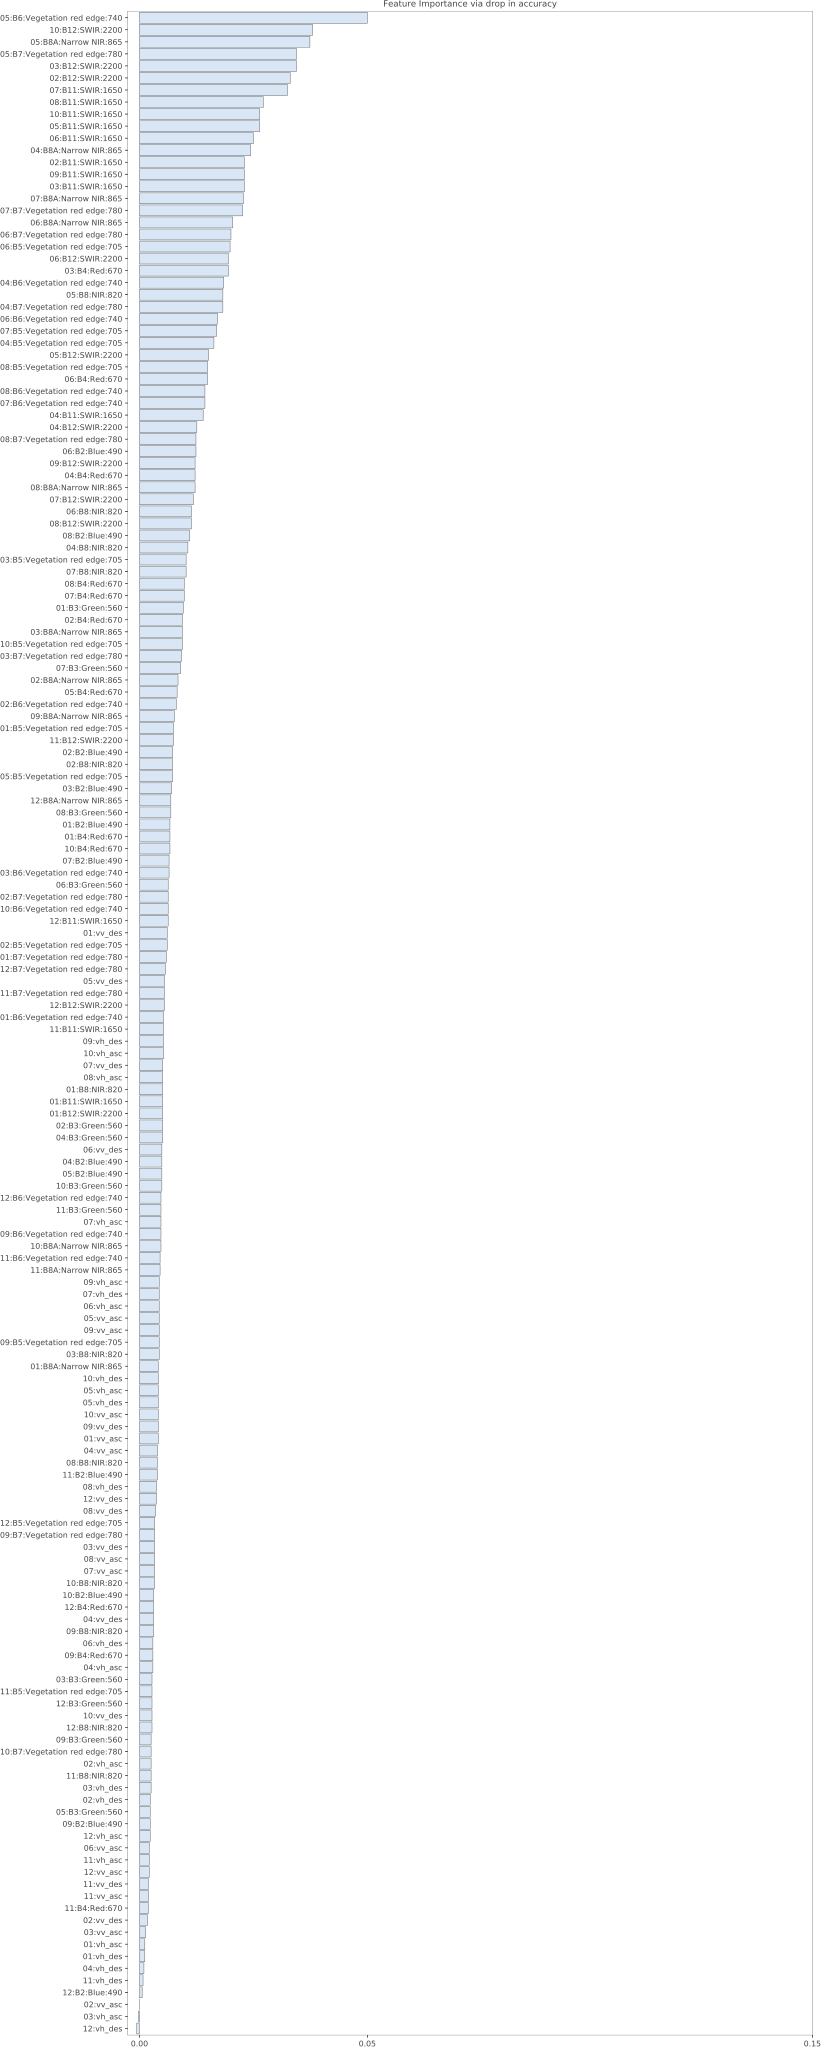

In [21]:
X_train, X_test, y_train, y_test = splits

rfpimp.plot_importances(rfpimp.importances(model, X_test, y_test), 
                        title="Feature Importance via drop in accuracy",
                        width=15, minheight=10)

### Permutation Importance

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
perm_importance = permutation_importance(model['rf'], X_test, y_test)

In [ ]:
plt.figure(figsize=(25, 15))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(featcols[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Accuracy")
plt.ylabel("Features")
plt.title("Feature Importance via avg drop in model accuracy (sklearn)")
plt.show()

### Drop-column Importance

In [ ]:
dropcol = rfpimp.dropcol_importances(model, X_train, y_train, X_valid=X_test, y_valid=y_test)
dropcol

In [ ]:
dropcol.plot(kind='barh', xlabel='Accuracy', ylabel='Features',
             title='Feature Importance via drop in model accuracy', 
             figsize=(25, 10))

In [ ]:
dropcols = dropcol[dropcol > 0.0].dropna().index.tolist()
dropcols

## Collinear Feature Inspection

### Feature Correlation

In [ ]:
rfpimp.plot_corr_heatmap(X_train, figsize=[15]*2)

In [ ]:
gfeatures = [['B2 – Blue', 'B3 – Green', 'B4 – Red', 'B5 – Vegetation red edge'],
       ['B6 – Vegetation red edge', 'B7 – Vegetation red edge', 'B8 – NIR',
       'B8A – Narrow NIR', 'B11 – SWIR', 'B12 – SWIR', 'Soil:BI2'], ['Vegetation:NDVI',
       'Water:NDWI', 'Vegetation:NDRE'], ['Haralick:Entropy', 'Haralick:Inverse Difference Moment'],
       'Haralick:Correlation', 'LBP:1', 'LBP:2', 'LBP:3', 'LBP:4', 'LBP:5', 'LBP:6', ['LBP:7', 'LBP:8'], ['LBP:9',
       'LBP:10'], ['LBP:11', 'LBP:12', 'LBP:13', 'LBP:14', 'LBP:15']]
rfpimp.plot_importances(rfpimp.importances(model, X_test, y_test, features=gfeatures),
                        title="Feature Importance via drop in model accuracy", 
                        width=15, minheight=5)

In [ ]:
# rfpimp.plot_dependence_heatmap(X_train, figsize=[20]*2)